In [1]:
from typing import Optional, List
from importlib import reload

from numpy import sqrt
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True,
               display_expand_data=False)

import plotly.express as px
import plotly.io as pio

from data import build_dataset_with_composites, get_factor_master, build_factor_data2
from stats import total_return

from market_feedback import  draw_market_feedback_scatter #px_scatter,



In [2]:
halflifes = [21, 63, 126, 252]
factor_data = build_factor_data2(halflifes)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
def format_date(date_str):
    return pd.to_datetime(date_str).strftime('%m/%d')


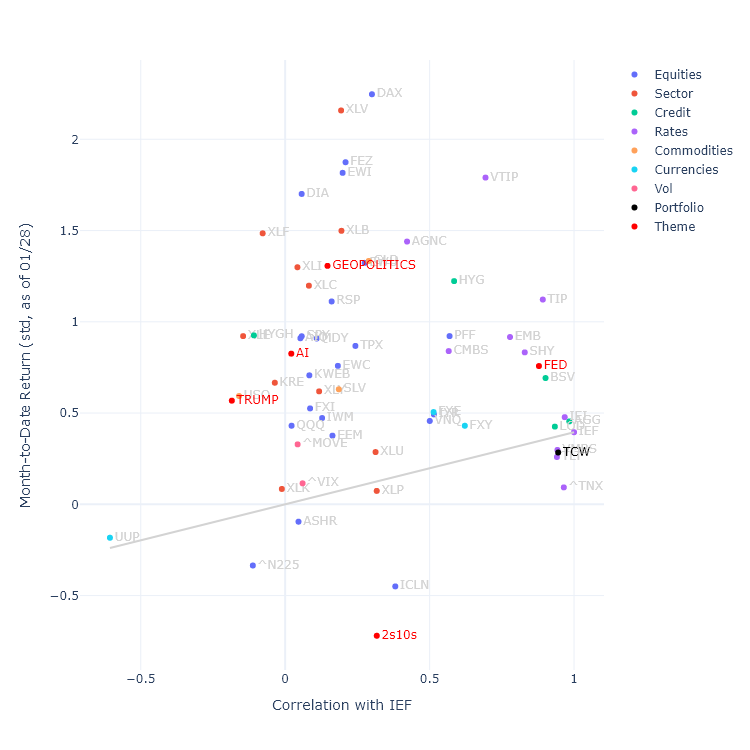

In [4]:
return_start = '2024-12-31'
return_end = '2025-01-28'
return_title = f'Month-to-Date Return (std, as of {format_date(return_end)})'


# return_start = '2025-01-21'
# return_end = '2025-01-28'
# return_title = f'5-day Return (std, {format_date(return_start)} - {format_date(return_end)})'

vol_type = 63
corr_type = 63
corr_asset = 'IEF'

fig = draw_market_feedback_scatter(factor_data, return_start, return_end, vol_type, corr_type, corr_asset, return_title)
fig.show(renderer='png')
fig.write_html('fed_feedback.html')
fig.write_image('fed_feedback.png')


# Correlation Matrix

In [5]:
def sort_assets(corr: pd.DataFrame, sorting_factor: str, factor_master: pd.DataFrame) -> pd.Index:
    df = (corr[[sorting_factor]]
          .join(factor_master[['asset_class', 'hyper_factor']])
          .assign(is_theme=lambda df: df['asset_class'] == 'Theme')
          .assign(is_sorting_factor=lambda df: df.index == sorting_factor)
          )
    sorted_index = df.sort_values(by=['is_sorting_factor', 'hyper_factor', 'is_theme', sorting_factor], 
                                  ascending=[False, False, True, False], key=abs).index
    return sorted_index


In [6]:
date_latest = factor_data.date.max().values
corr = factor_data.corr.sel(corr_type=corr_type, date=date_latest).to_pandas()

corr



def format_corr_matrix(corr: pd.DataFrame): # -> pd.io.formats.style.Styler:
    """
    Format the correlation matrix by adding asset class information and sorting.
    
    Parameters
    ----------
    corr : pd.DataFrame
        The correlation matrix with assets as both rows and columns.
    
    Returns
    -------
    pd.io.formats.style.Styler
        The formatted correlation matrix as a pandas Styler object.
    """
    # Sort the correlation matrix by asset class
    corr = corr
    
    # Style the correlation matrix
    styled_corr = corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=2)
    
    return styled_corr

# Apply the function to format the correlation matrix
formatted_corr = format_corr_matrix(corr) #, factor_master['asset_class'])
formatted_corr



factor_name_1,SPY,IWM,MDY,RSP,QQQ,DIA,XLK,XLI,XLF,KRE,XLC,XLE,XLY,XLB,XLV,XLU,XLP,IYR,VNQ,AIQ,ICLN,PFF,FEZ,EWU,DAX,EWC,EWI,^N225,TPX,FXI,ASHR,KWEB,EEM,LQD,BSV,HYG,HYGH,AGG,^TNX,SHY,IEI,IEF,TLT,TIP,VTIP,AGNC,VMBS,CMBS,EMB,GLD,SLV,USO,UUP,FXE,FXY,^VIX,^MOVE,MWTIX,TRUMP,FED,AI,GEOPOLITICS,2s10s
factor_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SPY,1.00,0.77,0.80,0.80,0.94,0.82,0.89,0.76,0.65,0.54,0.77,0.31,0.82,0.62,0.41,0.26,0.18,0.41,0.43,0.92,0.27,0.42,0.52,0.54,0.53,0.72,0.42,0.22,0.37,0.20,0.06,0.20,0.57,0.28,0.13,0.64,0.59,0.19,0.08,0.09,0.10,0.11,0.08,0.23,0.21,0.42,0.21,0.13,0.53,0.23,0.33,0.03,-0.18,0.19,-0.12,0.80,0.32,0.11,0.49,0.11,0.88,0.19,0.04
IWM,0.77,1.00,0.96,0.89,0.63,0.83,0.57,0.85,0.76,0.82,0.59,0.44,0.70,0.71,0.42,0.32,0.22,0.51,0.54,0.67,0.32,0.48,0.45,0.57,0.49,0.71,0.41,0.21,0.54,0.19,0.08,0.19,0.47,0.34,0.18,0.68,0.60,0.25,0.19,0.14,0.17,0.18,0.14,0.29,0.27,0.47,0.28,0.19,0.54,0.19,0.24,0.00,-0.22,0.20,-0.01,0.64,0.25,0.19,0.67,0.17,0.53,0.14,0.08
MDY,0.80,0.96,1.00,0.94,0.65,0.85,0.60,0.90,0.77,0.79,0.59,0.48,0.70,0.78,0.45,0.37,0.24,0.56,0.58,0.69,0.32,0.47,0.50,0.60,0.52,0.73,0.44,0.22,0.58,0.20,0.08,0.20,0.50,0.31,0.15,0.66,0.60,0.23,0.15,0.12,0.15,0.15,0.12,0.27,0.25,0.48,0.26,0.17,0.53,0.19,0.24,0.01,-0.21,0.21,-0.04,0.69,0.26,0.17,0.64,0.14,0.56,0.15,0.06
RSP,0.80,0.89,0.94,1.00,0.61,0.90,0.54,0.90,0.82,0.73,0.61,0.50,0.72,0.84,0.62,0.46,0.46,0.69,0.71,0.65,0.37,0.52,0.53,0.66,0.54,0.75,0.49,0.24,0.52,0.25,0.11,0.25,0.50,0.38,0.22,0.70,0.61,0.30,0.22,0.18,0.21,0.22,0.19,0.32,0.27,0.55,0.33,0.20,0.57,0.18,0.23,-0.05,-0.26,0.26,0.04,0.70,0.23,0.21,0.59,0.20,0.52,0.11,0.09
QQQ,0.94,0.63,0.65,0.61,1.00,0.63,0.96,0.59,0.43,0.37,0.74,0.16,0.78,0.44,0.21,0.10,0.01,0.21,0.22,0.95,0.23,0.29,0.48,0.41,0.47,0.60,0.34,0.18,0.31,0.17,0.06,0.17,0.56,0.20,0.06,0.53,0.47,0.11,0.01,0.03,0.04,0.05,0.03,0.15,0.14,0.30,0.14,0.06,0.44,0.22,0.33,0.06,-0.13,0.14,-0.16,0.72,0.31,0.06,0.33,0.05,0.95,0.19,0.04
DIA,0.82,0.83,0.85,0.90,0.63,1.00,0.56,0.83,0.86,0.73,0.63,0.44,0.72,0.73,0.61,0.31,0.40,0.50,0.52,0.65,0.21,0.46,0.44,0.58,0.49,0.68,0.41,0.24,0.41,0.20,0.05,0.20,0.43,0.31,0.18,0.63,0.57,0.23,0.15,0.14,0.15,0.15,0.11,0.29,0.28,0.42,0.26,0.16,0.50,0.12,0.19,-0.05,-0.14,0.14,-0.06,0.68,0.26,0.14,0.67,0.17,0.55,0.07,0.03
XLK,0.89,0.57,0.60,0.54,0.96,0.56,1.00,0.56,0.34,0.30,0.60,0.12,0.64,0.39,0.14,0.08,-0.10,0.15,0.15,0.93,0.20,0.23,0.45,0.35,0.43,0.56,0.29,0.16,0.27,0.17,0.07,0.17,0.56,0.12,0.02,0.44,0.42,0.05,-0.05,-0.00,-0.01,-0.00,-0.03,0.09,0.10,0.24,0.07,0.04,0.36,0.22,0.32,0.07,-0.11,0.12,-0.19,0.67,0.32,0.01,0.27,0.01,0.94,0.19,-0.00
XLI,0.76,0.85,0.90,0.90,0.59,0.83,0.56,1.00,0.76,0.69,0.50,0.49,0.63,0.76,0.49,0.41,0.26,0.52,0.54,0.63,0.20,0.39,0.42,0.51,0.44,0.66,0.36,0.22,0.45,0.14,0.06,0.15,0.41,0.22,0.08,0.55,0.58,0.13,0.07,0.06,0.06,0.06,0.04,0.19,0.19,0.41,0.16,0.07,0.42,0.14,0.15,-0.03,-0.14,0.15,-0.06,0.63,0.22,0.06,0.64,0.07,0.51,0.09,0.02
XLF,0.65,0.76,0.77,0.82,0.43,0.86,0.34,0.76,1.00,0.84,0.52,0.48,0.59,0.61,0.43,0.36,0.35,0.45,0.48,0.44,0.08,0.40,0.28,0.46,0.33,0.58,0.35,0.23,0.29,0.06,-0.05,0.07,0.24,0.20,0.09,0.54,0.55,0.13,0.08,0.05,0.07,0.07,0.03,0.19,0.20,0.40,0.17,0.15,0.36,-0.02,0.04,-0.09,-0.04,0.06,-0.11,0.60,0.22,0.05,0.80,0.07,0.32,-0.06,0.04


In [7]:
date_t0 = factor_data.date.max().values
date_t1  =factor_data.date[-63].values

corr_t0 = factor_data.corr.sel(corr_type=corr_type, date=date_t0).to_pandas()
corr_t1 = factor_data.corr.sel(corr_type=corr_type, date=date_t1).to_pandas()
corr_diff = corr_t0 - corr_t1
sorted_index = sort_assets(corr_t0, '2s10s', factor_master)
sorted_index_chg = sort_assets(corr_diff, '2s10s', factor_master)

format_corr_matrix(corr.loc[sorted_index, sorted_index])
format_corr_matrix(corr_diff.loc[sorted_index_chg, sorted_index_chg])

NameError: name 'factor_master' is not defined

# Draw correlation time series

In [ ]:
factor_data

In [ ]:
asset1 = 'SPY'
asset2 = 'IEF'
start_date = '2020'
start_date = None


df1  = factor_data.sel(factor_name=asset1, factor_name_1=asset2, date=slice('2024', None)).corr.to_pandas().T.stack()

from chart import draw_correlation, draw_volatility

fig1 = draw_correlation(factor_data.corr.sel(date=slice(start_date, None)), asset1, asset2, [21, 63, 126, 252])
fig1.show(renderer='png')

fig2 = draw_volatility(factor_data.vol.sel(date=slice(start_date, None)), asset1, [21, 63, 126, 252])
fig3 = draw_volatility(factor_data.vol.sel(date=slice(start_date, None)), asset2, [21, 63, 126, 252])

fig2.show()
fig3.show()

fig1.show(renderer='png')
# fig1.write_html('corr_ts.html')
# fig1.write_image('corr_ts.png')


In [ ]:
start_date = '2015'
start_date = None

corr_pairs = [('SPY', 'IEF'),
            #   ('SHY', 'IEF'), 
            #   ('2s10s', 'SPY'), 
            #   ('2s10s', 'IEF'), 
            #   ('2s10s', 'HYGH'), 
            #   ('2s10s', 'HYG'), 
            #   ('2s10s', 'LQD'), 
              ('2s10s', 'LQDH'), 
            #   ('2s10s', 'VMBS'), 
            #   ('2s10s', 'AGNC')
              ]

for asset1, asset2 in corr_pairs:
    fig = draw_correlation(factor_data.corr.sel(date=slice(start_date, None)), asset1, asset2, [21, 63, 126, 252])
    fig.show(renderer='png')
    # fig.write_html(f'corr_{asset1}_{asset2}.html')
    # fig.write_image(f'corr_{asset1}_{asset2}.png')

In [15]:
fig1.write_html('corr_ts.html')
fig1.write_image('corr_ts.png')

fig.write_html('fed_feedback.html')
fig.write_image('fed_feedback.png')

In [ ]:
# factor_data.ret.sel(asset=[asset1, asset2]).plot(hue='asset')
factor_data.ret.sel(asset='IWM').plot()
factor_data.ret.sel(asset='IEF').plot()
factor_data.ret.sel(asset='SHY').plot()

factor_data.ret.sel(asset='2s10s').plot()